In [1]:
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as sns
import pandas as pd
from random import random
import sys, time
print(f"running python {sys.version}")

# condtional printing untility, only prints important messages
global verbosity
verbosity = 5
def pp(importance, message):
    if importance > 10-verbosity:
        print(message)


running python 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


Testing the learning curve mathematics based on three parameters.


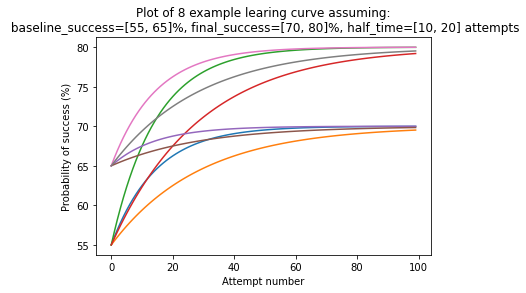

In [2]:
print("Testing the learning curve mathematics based on three parameters.")

def success_p(attempt, baseline_success, final_success, half_time):
    failure_risk = 0.5**(attempt/half_time) # in range 0 to 1
    return final_success - failure_risk *(final_success - baseline_success)

def plot_example_learning_curves():
    bs = [55, 65] # percent
    fs =[70,80] # percent
    ht = [10, 20]
    fig, ax = plt.subplots()
    for baseline_success in bs:
        for final_success in fs: # percent
            for half_time in ht: # cases
                x = np.array(range(0, 100))  
                y = success_p(attempt = x, baseline_success = baseline_success, final_success = final_success, half_time = half_time)
                plt.plot(x, y)  
    plt.title(f"Plot of {len(bs)*len(fs)*len(ht)} example learing curve assuming:\n baseline_success={bs}%, final_success={fs}%, half_time={ht} attempts")
    ax.set_ylabel('Probability of success (%)')
    ax.set_xlabel('Attempt number')
    plt.show()  

plot_example_learning_curves()

Generated attempt success curves for 2000 students.
      
    baseline_success_p = 0.43 (sd: 0.13)
    final_success_p = 0.63 (sd: 0.14)
    attempts_to_half_improvement = 12.42 (sd: 6.41)
    


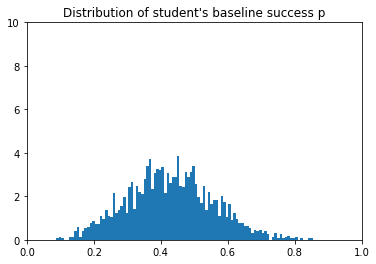

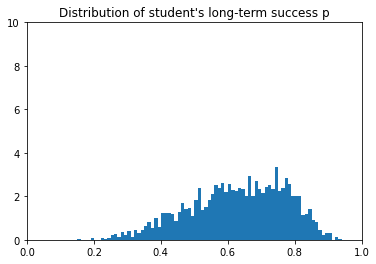

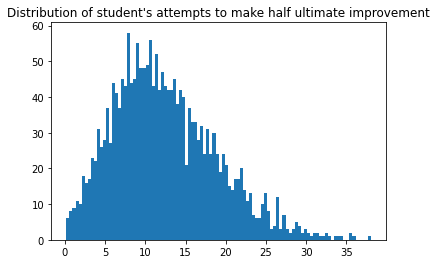

Generated attempt success curves for 2000 students.


In [3]:
##
## Create a population of learning curves
## (as three seperate arrays of the defining parameters)
## 


"""
Make mock curves as defined by three lists of defining parameters:
* baseline success probablity (ie how well the student will do on first ever attempt)
* final sussess probability (ie how well this stuedent will eventually become)
* number of attempts to achieve half the improvement from baseline to final proficency
"""
def generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n = 2000):
    #baseline_success_p = 1/(1+np.random.exponential(odds_of_failure,n))
    baseline_success_p = np.random.beta(baseline_alpha, baseline_beta,n)
    failure_p = 1-baseline_success_p # baseline risk of failure 
    final_success_p = 1-(failure_p * (1-fall_in_failure_rate*np.random.random(n)))
    attempts_to_half_improvement = np.random.rayleigh(half_time_mean,n)
    return {"bsp": baseline_success_p, "fsp": final_success_p, "athi": attempts_to_half_improvement}

""" 
Describe a set of stuent curves, and optionally plot.
Return a dictionary of values.                      
"""
def describe_student_curves(sc, plots=False):
    print(f"""      
    baseline_success_p = {sc['bsp'].mean():0.2f} (sd: {sc['bsp'].std():0.2f})
    final_success_p = {sc['fsp'].mean():0.2f} (sd: {sc['fsp'].std():0.2f})
    attempts_to_half_improvement = {sc['athi'].mean():0.2f} (sd: {sc['athi'].std():0.2f})
    """)    
    if plots:
        n = len(sc['bsp'])
        count, bins, ignored = plt.hist(sc['bsp'], bins=100, density=True)
        plt.axis((0,1,0,n/200))
        plt.title("Distribution of student's baseline success p")
        plt.show()  
        count, bins, ignored = plt.hist(sc['fsp'], bins=100, density=True, range=(0,1))
        plt.title("Distribution of student's long-term success p")
        plt.axis((0,1,0,n/200))
        plt.show()  
        count, bins, ignored = plt.hist(sc['athi'], bins=100, density=False)
        plt.title("Distribution of student's attempts to make half ultimate improvement")
        plt.show()  
    return {
      "baseline_success_p": sc['bsp'].mean(),
      "baseline_success_p_sd": sc['bsp'].std(),     
      "final_success_p": sc['fsp'].mean(), 
      "final_success_p_sd": sc['fsp'].std(),
      "attempts_to_half_improvement": sc['athi'].mean(),
      "attempts_to_half_improvement_sd": sc['athi'].std()
    }

""" 
Implement the student curve by calculating the probability of success at a given attempt. 
""" 
def student_p(student_id, attempt, sc):
    failure_risk = 0.5**(attempt/sc['athi'][student_id]) # in range 0 to 1
    return sc['fsp'][student_id] - failure_risk *(sc['fsp'][student_id] - sc['bsp'][student_id])
        
"""
create a 2d array of student success probabilities
"""
def student_attempt_success(sc, attempts=20):
    n = len(sc['bsp'])
    students = np.array(range(0, n))
    attempts = np.array(range(0, attempts))
    # make a matrix from the above two arrays
    return student_p(students[:,np.newaxis],attempts[np.newaxis,:],sc)    

def succeeded(p, success_relative_increase):
    random_roll = np.random.random(p.shape)
    modified_success = 1 - ((1-p)/(1+success_relative_increase))
    pp(7, f"P initial: {p.mean():0.3}  P after adjustment: {modified_success.mean():0.3}; dice: {random_roll.mean():0.3}")
    return random_roll < modified_success

def create_mock_students(n = 2000, chattiness = 5):
    # baseline "beta" curve defining initial success rate
    baseline_alpha = 6
    baseline_beta = 8
    fall_in_failure_rate = .7 # how much do they improve (or does their failure rate drop)
    half_time_mean = 10 # how quickly to students learn?
    sc = generate_student_curves(baseline_alpha, baseline_beta, fall_in_failure_rate, half_time_mean, n)
    sac = student_attempt_success(sc, attempts=20)
    pp(chattiness, f"Generated attempt success curves for {n} students.")
    d = describe_student_curves(sc, plots=chattiness>5)
    pp(chattiness, f"Generated attempt success curves for {n} students.")
    return sc, sac, d


sc, sac, student_curve_attributes = create_mock_students(chattiness=10)       

In [4]:
def generate_trial_data(subject_n, attempt_n, trials, groups, sac):
    attempt_data = []
    participant_data = []
    trial_data = []
    totals = {}
    attempts_per_group = trials*subject_n*attempt_n
    print(f"{attempts_per_group} total attempts per group")
    for trial in range(trials):
        pp(7,f"=======\ntrial {trial}")
        for group, success_relative_increase in groups.items():
            pp(6, f"group: {group}")
            students = sac[np.random.choice(len(sac), subject_n, replace=True), :attempt_n]
            pp(5,students)
            result = succeeded(students,success_relative_increase)
            pp(6, f"result: {result}")
            pp(6, f"{group} success: {result.sum()}/{(result.size)} ({100*result.sum()/(result.size):3.1f}%)" )
            totals[group] = totals.get(group, 0) + result.sum()
            rec = {'trial': trial, 'group': group, "result": result.sum()}
            trial_data.append(rec)
            for p in range(subject_n):
                participant_results = result[p]
                rec["p"] = f"{group}{p}"
                prec = {**rec, "result": participant_results.sum()}
                pp(1,prec)
                participant_data.append(prec)
                for i in range(len(participant_results)):
                    irec = {**rec, "pint": p, "i": i, "result": 1 if participant_results[i] else 0}
                    pp(1,irec)
                    attempt_data.append(irec)

    pp(5, f"totals: {totals}")
    td = pd.DataFrame(trial_data)
    partd = pd.DataFrame(participant_data)
    ad = pd.DataFrame(attempt_data)
    return td, partd, ad, totals

In [5]:
def test_trial_generation(groups, subject_n = 5, attempt_n = 5, trials = 1000, plots = True):
    global verbosity
    verbosity = 10 if trials < 3 else 6 if trials < 10 else 2  # range of 0-10
    print(f"verbosity: {verbosity}")
    print(f"{trials} trials sampling {subject_n} for each of {len(groups)} groups out of {sac.shape[0]} students, each having {attempt_n} attempts")
    td, partd, ad, totals = generate_trial_data(subject_n, attempt_n, trials, groups, sac)

    def sumarise_trial(totals, attempts_per_group):
        results_percents = {}
        for group, result in totals.items():
            print(group, result)
            results_percents[group] = 100*result/attempts_per_group
        print(results_percents)
    sumarise_trial(totals, attempts_per_group=subject_n*attempt_n*trials)
    if plots:
        whisker = 5
        ax = sns.boxplot(x="group", y="result", data=td, whis=[whisker, 100-whisker])
        #ax = sns.swarmplot(x="group", y="result", data=td)
        ax = sns.violinplot(x="group", y="result", data=td)

        plt.title(f"Successful attempts in each arm of {trials} trials of {subject_n} students, each having {attempt_n} attempts. (Whiskers at {whisker}% and {100-whisker}%)")
        plt.show()

        pd.crosstab(ad.result, ad.i).plot(kind='bar')
        plt.title("Success per iteration")
        plt.show()

        ad.groupby(['group', 'i']).result.sum().plot(stacked=True,kind='bar')
        plt.title("Success per iteration")
        plt.show()
    return td, partd, ad

groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "nodif": 0}
td, partd, ad = test_trial_generation(groups, plots = False)

verbosity: 2
1000 trials sampling 5 for each of 5 groups out of 2000 students, each having 5 attempts
25000 total attempts per group
control 11601
interventionA 12563
interventionB 13667
interventionC 16531
nodif 11488
{'control': 46.404, 'interventionA': 50.252, 'interventionB': 54.668, 'interventionC': 66.124, 'nodif': 45.952}


In [6]:
"""
# can't get this to work
lcpd = ad.groupby(by=['group','i'])
fig, ax = plt.subplots()
lcpd.mean().result.plot.bar(ax=ax, capsize=4, rot=0)
plt.title("Success per iteration")
plt.show()
"""



'\n# can\'t get this to work\nlcpd = ad.groupby(by=[\'group\',\'i\'])\nfig, ax = plt.subplots()\nlcpd.mean().result.plot.bar(ax=ax, capsize=4, rot=0)\nplt.title("Success per iteration")\nplt.show()\n'

In [7]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols
from statsmodels.formula.api import gee



"""
see: https://www.statsmodels.org/dev/_modules/statsmodels/genmod/cov_struct.html#CovStruct 
"""
def fit_models(ad, trials_to_test, tests):
    report_style = 'flat'
    outcomes = {}
    for trial in trials_to_test:
        pp(5, f"#### trial: {trial} #####")
        itd = ad.query(f"trial == {trial}") # individual trial data
        c = itd[['group','result']].groupby("group").sum().reset_index().set_index("group")
        for model in tests:
            pp(5, f"#### {model}")
            if model == 'ols':
                res = ols('result ~ C(group)+i', data=itd).fit()
            if model == 'geeB':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'geeBI':
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'geeBIs': # drop the "i" variable (which tracks attempt number)
                fam = sm.families.Binomial()
                ind = sm.cov_struct.Independence()
                mod = gee("result ~ C(group)", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            if model == 'gee':
                fam = sm.families.Poisson()
                ind = sm.cov_struct.Exchangeable()
                mod = gee("result ~ C(group)+i", "p", itd,
                              cov_struct=ind, family=fam)
                res = mod.fit()
            pp(3, res.summary())
            p=res.pvalues[1]
            outcome = 'ns' if p > 0.05 else 'wrong' if c['result'][0] > c['result'][1] else 'sig' if p> 0.01 else 'vsig'
            pp(6, f"******************p = {p:0.6f} -{outcome}")
            if report_style == 'flat':
                key = f"{model}{outcome}"
                if outcomes.get(key, -1) == -1:
                    outcomes.update({f"{model}wrong":0,f"{model}ns":0,f"{model}sig":0,f"{model}vsig":0})
                outcomes[key] += 1
            else:
                outcomes[model] = outcomes.get(model,{'wrong':0,'ns':0,'sig':0,'vsig':0})
                outcomes[model][outcome] = 1 + outcomes[model].get(outcome, 0)

    return(outcomes)


"""
{'gee': {'sig': 228, 'vsig': 291, 'insign': 464, 'wrong': 17},
 'ols': {'vsig': 719, 'sig': 108, 'insign': 156, 'wrong': 17},
 'geeB': {'sig': 225, 'vsig': 329, 'insign': 429, 'wrong': 17}}
{'geeBI': {'wrong': 17, 'insign': 446, 'sig': 214, 'vsig': 323}}
'geeBIs': {'wrong': 17, 'insign': 446, 'sig': 215, 'vsig': 322}

"""

"\n{'gee': {'sig': 228, 'vsig': 291, 'insign': 464, 'wrong': 17},\n 'ols': {'vsig': 719, 'sig': 108, 'insign': 156, 'wrong': 17},\n 'geeB': {'sig': 225, 'vsig': 329, 'insign': 429, 'wrong': 17}}\n{'geeBI': {'wrong': 17, 'insign': 446, 'sig': 214, 'vsig': 323}}\n'geeBIs': {'wrong': 17, 'insign': 446, 'sig': 215, 'vsig': 322}\n\n"

verbosity: 2
1000 trials sampling 200 for each of 6 groups out of 2000 students, each having 20 attempts
4000000 total attempts per group
control 2058828
interventionA 2235331
interventionB 2381808
interventionC 2786915
interventionD 2923165
nodif 2057976
{'control': 51.4707, 'interventionA': 55.883275, 'interventionB': 59.5452, 'interventionC': 69.672875, 'interventionD': 73.079125, 'nodif': 51.4494}


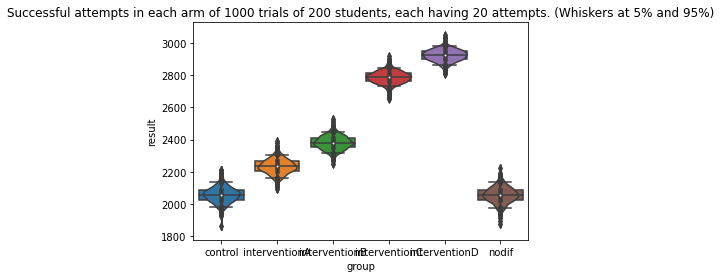

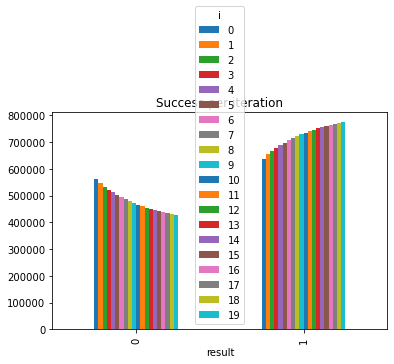

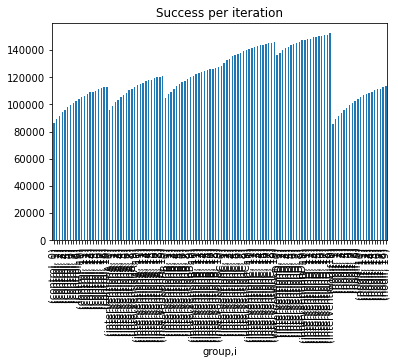

In [8]:
groups = {"control": 0, "interventionA":0.1, "interventionB":0.2, "interventionC":0.6, "interventionD": 0.8, "nodif": 0}
td, partd, ad = test_trial_generation(groups, subject_n = 200, attempt_n = 20, trials = 1000, plots = True)

In [9]:
def run_sym():
    pairs = {'none': ['control','nodif'],
             'vsmall': ['control','interventionA'],
             'small': ['control','interventionB'],
             'big': ['control', 'interventionC'],
             'huge': ['control', 'interventionD'],
             'upper': [ 'interventionC', 'interventionD']
            }
    """
    {'control': 51.6145, 'interventionA': 55.88775, 'interventionB': 59.653125, 
    'interventionC': 69.713125, 'interventionD': 73.108, 'nodif': 51.515}    

    """    
    
    tests = ['geeBI']
    trials_to_test = range(int(len(td)/len(groups)))
    global verbosity
    verbosity = 6 if len(trials_to_test) < 5 else 4
    sym_results = []
    for comparision, pair in pairs.items():
        for students_per_group in [20, 30,50, 75, 100,200]:#[5, 10]:
            for attempts_per_student in [5, 10, 20]: #[5,10]:
                query = f"group == {pair} and pint < {students_per_group} and i < {attempts_per_student}"
                trial_data = ad.query(query)
                pp(10, f"`{query}` ({len(trial_data)} total attempts)")
                run_results = fit_models(ad=trial_data, trials_to_test=trials_to_test, tests=tests)
                pp(10, f"run_results: {run_results}")
                sym_results.append(
                    {"comparision":comparision, 
                     "students_per_group": students_per_group, 
                     "attempts_per_student": attempts_per_student,
                     "groupA": pair[0], "groupB": pair[1], 
                     "total_attemps": len(trial_data),
                     'query': query, 'time':time.time()*1000})
    return pd.DataFrame(sym_results)

In [10]:
test1 = run_sym() 

`group == ['control', 'nodif'] and pint < 20 and i < 5` (200000 total attempts)
run_results: {'geeBIwrong': 32, 'geeBIns': 941, 'geeBIsig': 18, 'geeBIvsig': 9}
`group == ['control', 'nodif'] and pint < 20 and i < 10` (400000 total attempts)
run_results: {'geeBIwrong': 32, 'geeBIns': 933, 'geeBIsig': 29, 'geeBIvsig': 6}
`group == ['control', 'nodif'] and pint < 20 and i < 20` (800000 total attempts)
run_results: {'geeBIwrong': 28, 'geeBIns': 941, 'geeBIsig': 23, 'geeBIvsig': 8}
`group == ['control', 'nodif'] and pint < 30 and i < 5` (300000 total attempts)
run_results: {'geeBIwrong': 28, 'geeBIns': 943, 'geeBIsig': 22, 'geeBIvsig': 7}
`group == ['control', 'nodif'] and pint < 30 and i < 10` (600000 total attempts)
run_results: {'geeBIwrong': 36, 'geeBIns': 929, 'geeBIsig': 29, 'geeBIvsig': 6}
`group == ['control', 'nodif'] and pint < 30 and i < 20` (1200000 total attempts)
run_results: {'geeBIwrong': 35, 'geeBIns': 941, 'geeBIsig': 17, 'geeBIvsig': 7}
`group == ['control', 'nodif'] and 

`group == ['control', 'interventionB'] and pint < 100 and i < 10` (2000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 102, 'geeBIsig': 176, 'geeBIvsig': 722}
`group == ['control', 'interventionB'] and pint < 100 and i < 20` (4000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 52, 'geeBIsig': 97, 'geeBIvsig': 851}
`group == ['control', 'interventionB'] and pint < 200 and i < 5` (2000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 39, 'geeBIsig': 103, 'geeBIvsig': 858}
`group == ['control', 'interventionB'] and pint < 200 and i < 10` (4000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 4, 'geeBIsig': 19, 'geeBIvsig': 977}
`group == ['control', 'interventionB'] and pint < 200 and i < 20` (8000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 3, 'geeBIsig': 7, 'geeBIvsig': 990}
`group == ['control', 'interventionC'] and pint < 20 and i < 5` (200000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 233, 'geeBIsig':

run_results: {'geeBIwrong': 2, 'geeBIns': 779, 'geeBIsig': 145, 'geeBIvsig': 74}
`group == ['interventionC', 'interventionD'] and pint < 50 and i < 20` (2000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 710, 'geeBIsig': 171, 'geeBIvsig': 119}
`group == ['interventionC', 'interventionD'] and pint < 75 and i < 5` (750000 total attempts)
run_results: {'geeBIwrong': 3, 'geeBIns': 815, 'geeBIsig': 110, 'geeBIvsig': 72}
`group == ['interventionC', 'interventionD'] and pint < 75 and i < 10` (1500000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 706, 'geeBIsig': 169, 'geeBIvsig': 125}
`group == ['interventionC', 'interventionD'] and pint < 75 and i < 20` (3000000 total attempts)
run_results: {'geeBIwrong': 0, 'geeBIns': 590, 'geeBIsig': 192, 'geeBIvsig': 218}
`group == ['interventionC', 'interventionD'] and pint < 100 and i < 5` (1000000 total attempts)
run_results: {'geeBIwrong': 1, 'geeBIns': 779, 'geeBIsig': 126, 'geeBIvsig': 94}
`group == ['interventionC', 'inte

In [11]:
test1


,comparision,students_per_group,attempts_per_student,groupA,groupB,total_attemps,query,time
0,none,20,5,control,nodif,200000,"group == ['control', 'nodif'] and pint < 20 an...",1.626428e+12
1,none,20,10,control,nodif,400000,"group == ['control', 'nodif'] and pint < 20 an...",1.626428e+12
2,none,20,20,control,nodif,800000,"group == ['control', 'nodif'] and pint < 20 an...",1.626428e+12
3,none,30,5,control,nodif,300000,"group == ['control', 'nodif'] and pint < 30 an...",1.626428e+12
4,none,30,10,control,nodif,600000,"group == ['control', 'nodif'] and pint < 30 an...",1.626428e+12
...,...,...,...,...,...,...,...,...
103,upper,100,10,interventionC,interventionD,2000000,"group == ['interventionC', 'interventionD'] an...",1.626434e+12
104,upper,100,20,interventionC,interventionD,4000000,"group == ['interventionC', 'interventionD'] an...",1.626434e+12
105,upper,200,5,interventionC,interventionD,2000000,"group == ['interventionC', 'interventionD'] an...",1.626434e+12
106,upper,200,10,interventionC,interventionD,4000000,"group == ['interventionC', 'interventionD'] an...",1.626434e+12


In [ ]:
ad.head()

In [12]:
test1.to_csv("powertests4.csv")